In [1]:
"""
*Filename: DeepNetTrainer
*Description: The original Deep Sets Trainer file which uses the standard DeepSets architecture and 
the base track and jet features to regress the bhadron features
Date: 16/02/2023
Author: Kaylen Smith Darnbrook
"""

'\n*Filename: DeepNetTrainer\n*Description: The original Deep Sets Trainer file which uses the standard DeepSets architecture and \nthe base track and jet features to regress the bhadron features\nDate: 16/02/2023\nAuthor: Kaylen Smith Darnbrook\n'

In [2]:
#Starts by importing the relevant python modules
import DeepSetNeuralNetArchitecture as DSNNA
import os
from sklearn.feature_selection import mutual_info_regression
from tensorflow_probability import distributions
import seaborn as sns
import keras.backend as k
from keras import callbacks
import keras
import numpy as np
import uproot
import awkward as ak
import sklearn as sk
from numpy.lib.recfunctions import structured_to_unstructured
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.preprocessing import StandardScaler
import pandas as pd
from hffrag import fixedbinning
from hffragJetNetwork2 import bhadsNet
from hffrag import binneddensity
from timeit import default_timer as timer
import matplotlib.pyplot as plt
%matplotlib inline

2023-02-26 16:13:58.817023: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-26 16:13:58.976293: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-26 16:13:58.980985: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-26 16:13:58.981003: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

number of jets to train on:
141329


/home/physics/phujdj/DeepLearningParticlePhysics/hffrag.py:136: RuntimeWarning: overflow encountered in sinh
  pzs = numpy.where(mask, pts, pts * numpy.sinh(etas))


In [3]:
#Format the style and format of the matplotlib plots
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rc('text', usetex=False)
plt.rc('font', family='Times New Roman')
%config InlineBackend.print_figure_kwargs = {'facecolor': "w"}


In [4]:
# The data is being stored in a tree datastructure.
# We access the charm root using this command
tree = uproot.open("hffrag.root:CharmAnalysis")


In [5]:
# Initial parameters
# This value is introduced to ensure arrays are regular (Of the same size). They will be masked later by the network
MASKVAL = -999
MAXTRACKS = 32  # This value is the maximum number of tracks allowed per event
BATCHSIZE = 128  # This is the batch size of the mini batches used during training
EPOCHS = 1000  # This is the default number of epochs for which the neural network will train providing that early stopping does not occur
MAXEVENTS = 1e20  # This is the maximum number of events that will the program will accept
LR = 1e-4 # This is the default learning rate


In [6]:
#Calculates the mutual information scores between the input feature matrix and targets.
def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores")
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores
    
#Plots the mutual information scores.
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Informarion Scores")


In [7]:
# Select the features we wish to study
track_features = ["AnalysisTracks_pt", "AnalysisTracks_eta", "AnalysisTracks_phi", "AnalysisTracks_z0sinTheta",
                  "AnalysisTracks_d0sig", "AnalysisTracks_d0", "AnalysisTracks_d0sigPV", "AnalysisTracks_d0PV"]
jet_features = ["AnalysisAntiKt4TruthJets_pt", "AnalysisAntiKt4TruthJets_eta", "AnalysisAntiKt4TruthJets_phi", "AnalysisAntiKt4TruthJets_m","AnalysisAntiKt4TruthJets_ghostB_pdgId",
                "AnalysisAntiKt4TruthJets_ghostB_pt", "AnalysisAntiKt4TruthJets_ghostB_eta","AnalysisAntiKt4TruthJets_ghostB_phi", "AnalysisAntiKt4TruthJets_ghostB_m"]
reconstructed_jet_features = ["AnalysisJets_pt_NOSYS", "AnalysisJets_eta", "AnalysisJets_phi", "AnalysisJets_m"]

In [7]:
# Select the features we wish to study
track_features = ["AnalysisTracks_pt", "AnalysisTracks_eta", "AnalysisTracks_phi", "AnalysisTracks_z0sinTheta",
                  "AnalysisTracks_d0sig", "AnalysisTracks_d0", "AnalysisTracks_d0sigPV", "AnalysisTracks_d0PV"]
jet_features = ["AnalysisAntiKt4TruthJets_pt", "AnalysisAntiKt4TruthJets_eta", "AnalysisAntiKt4TruthJets_phi", "AnalysisAntiKt4TruthJets_m","AnalysisAntiKt4TruthJets_ghostB_pdgId",
                "AnalysisAntiKt4TruthJets_ghostB_pt", "AnalysisAntiKt4TruthJets_ghostB_eta","AnalysisAntiKt4TruthJets_ghostB_phi", "AnalysisAntiKt4TruthJets_ghostB_m"]

In [8]:
# Read in the data from the root file
features = tree.arrays(jet_features+track_features+reconstructed_jet_features, entry_stop=MAXEVENTS)

In [20]:
# Select the events of interest
events = features[ak.sum(
    features["AnalysisAntiKt4TruthJets_pt"] > 25000, axis=1) > 0]

In [21]:
# Displays the number of jets being trained on
jets = events[jet_features][:, 0]
print("The number of jets to train on is: ", len(jets))
print("The number of track features is: ", len(track_features))

The number of jets to train on is:  141329
The number of track features is:  8


In [22]:
# Select tracks from the events
tracks = events[track_features]
rejets = events[reconstructed_jet_features]

# Match the tracks to the jets
matchedtracks = tracks[DSNNA.Match_Tracks(jets, tracks)]

# Pad and Flatten the data
matchedtracks = DSNNA.flatten(matchedtracks, MAXTRACKS)

In [23]:
#Selects the b-jets with bhadrons with a transverse momentum over 5000 MeV
bjets = ak.sum(jets["AnalysisAntiKt4TruthJets_ghostB_pt"] > 5000, axis=1) > 0
jets = jets[bjets]
rejets = rejets[bjets]
rejets = DSNNA.pad(rejets,MAXTRACKS)[:,0]


# Obtain the pt, eta and phi of each b hadron jet
bhads_pt = jets["AnalysisAntiKt4TruthJets_ghostB_pt"][:, 0].to_numpy()
bhads_eta = jets["AnalysisAntiKt4TruthJets_ghostB_eta"][:,0].to_numpy()
bhads_phi = jets["AnalysisAntiKt4TruthJets_ghostB_phi"][:,0].to_numpy()
bhads_m = jets["AnalysisAntiKt4TruthJets_ghostB_m"][:,0].to_numpy()
bhads_PGID = jets["AnalysisAntiKt4TruthJets_ghostB_pdgId"][:,0].to_numpy()

jets_pt = jets["AnalysisAntiKt4TruthJets_pt"].to_numpy()
jets_eta = jets["AnalysisAntiKt4TruthJets_eta"].to_numpy()
jets_phi = jets["AnalysisAntiKt4TruthJets_phi"].to_numpy()
jets_m = jets["AnalysisAntiKt4TruthJets_m"].to_numpy()
b_jets = np.stack([jets_pt,jets_eta,jets_phi, jets_m], axis = -1)

rejets_pt = rejets["AnalysisJets_pt_NOSYS"].to_numpy()
rejets_eta = rejets["AnalysisJets_eta"].to_numpy()
rejets_phi = rejets["AnalysisJets_phi"].to_numpy()
rejets_m = rejets["AnalysisJets_m"].to_numpy()
re_b_jets = np.stack([rejets_pt,rejets_eta,rejets_phi, rejets_m], axis = -1)

bhads = np.stack([bhads_pt,bhads_eta,bhads_phi, bhads_m],axis = -1) #Combine the momentum, eta and phi for each jet into one array

print("There are {} outputs".format(np.shape(bhads)[1])) # Display the number of target features the neural network will predict
matchedtracks = matchedtracks[bjets]
print("There are {} inputs".format(np.shape(matchedtracks)[1])) # Display the number of target features the neural network will use in it's predictions

There are 4 outputs
There are 32 inputs


In [24]:
# Transform the jet and tracks to unstructed data.
rejets = rejets.to_numpy()
rejets = structured_to_unstructured(rejets[reconstructed_jet_features])
jets = structured_to_unstructured(jets[jet_features[:-5]])
matchedtracks = structured_to_unstructured(matchedtracks)

In [25]:
rejets_pt = re_b_jets[:,0].reshape(-1,1)
rejets_eta = re_b_jets[:,1].reshape(-1,1)
rejets_phi = re_b_jets[:,2].reshape(-1,1)

re_b_jets_pep = np.concatenate([rejets_pt,rejets_eta,rejets_phi], axis = -1) 
print(re_b_jets_pep.shape)

# Convert the coordinates of the b jets and tracks to cartesian coordinates
tracks_p = DSNNA.pt_eta_phi_2_px_py_pz_tracks(matchedtracks.to_numpy())
bhads = DSNNA.pt_eta_phi_2_px_py_pz_jets(bhads)
reconjet_p = DSNNA.pt_eta_phi_2_px_py_pz_jets(re_b_jets)
b_jets = DSNNA.pt_eta_phi_2_px_py_pz_jets(b_jets)
re_b_jets_m = re_b_jets[:,-1].reshape(-1,1)
# Combine the momenta of the tracks with the rest of the track features to form the track dataset
tracks = np.concatenate([tracks_p, matchedtracks[:, :, 3:].to_numpy()], axis=2)
re_b_jets = np.concatenate([reconjet_p,re_b_jets_pep,re_b_jets_m], axis = -1)

#Mask out the MASKVALs used to pad the arrays
tracks = np.ma.masked_values(tracks,-999)
#Mask out the MASKVALs used to pad the reconstructed jets
re_b_jets = np.ma.masked_values(re_b_jets,-999)

(68143, 3)


/home/physics/phujdj/DeepLearningParticlePhysics/DeepSetNeuralNetArchitecture.py:146: RuntimeWarning: overflow encountered in sinh
  pzs = np.where(mask1 | mask3, pts, pts * np.sinh(etas))


In [26]:
print(np.shape(tracks))
print(np.shape(b_jets))
print(np.shape(re_b_jets))
print(np.shape(bhads_pt))

(68143, 32, 8)
(68143, 3)
(68143, 7)
(68143,)


In [27]:
#Standardize the track inputs
Scaler = StandardScaler()
Num_events, Num_tracks, Num_features = np.shape(tracks)
tracks = np.reshape(tracks, newshape=(-1, Num_features))
tracks = Scaler.fit_transform(tracks)
tracks = np.reshape(tracks, newshape=(Num_events, Num_tracks, Num_features))

In [28]:
b_jets_mag = np.linalg.norm(b_jets[:,:3], axis = 1)
re_b_jets_mag = np.linalg.norm(re_b_jets[:,:3], axis = 1)
bhads_mag = np.linalg.norm(bhads[:,:3], axis = 1)
tracks_Momentum = np.sum(np.linalg.norm(tracks[:,:,:3], axis = 2))

bhads_fractions_px = bhads[:,0]/b_jets[:,0]
bhads_fractions_py = bhads[:,1]/b_jets[:,1]
bhads_fractions_pz = bhads[:,2]/b_jets[:,2]
bhads_fractions_pt = bhads_pt/jets_pt
print(bhads_fractions_px.shape)

b_jets_energy = np.sqrt((jets_m**2) + (b_jets_mag**2))
print(b_jets_energy.shape, jets_m.shape)

re_b_jets_energy = np.sqrt((re_b_jets_m[:,0]**2) + (re_b_jets_mag**2))
print(re_b_jets_energy.shape)


b_jets_energy_pt = np.sqrt((b_jets[:,0]**2) + (jets_m**2))
b_jets_energy_pt.shape


re_b_jets_energy_pt = np.sqrt((re_b_jets[:,0]**2) + (re_b_jets_m[:,0]**2))
re_b_jets_energy_pt.shape


b_jet_energy_mass_ratio = b_jets_energy/jets_m
b_jet_energy_mass_ratio[np.isinf(b_jet_energy_mass_ratio)] = np.median(b_jet_energy_mass_ratio)

re_b_jet_energy_mass_ratio = re_b_jets_energy/re_b_jets_m[:,0]
re_b_jet_energy_mass_ratio[np.isinf(re_b_jet_energy_mass_ratio)] = np.median(re_b_jet_energy_mass_ratio)


bhads_projection = ((bhads[:,:3]*b_jets[:,:3]).sum(axis = 1))/(b_jets_mag**2)


print(b_jet_energy_mass_ratio.shape)
bhads_energy = np.sqrt((bhads_m**2) + (bhads_mag**2))
bhads_energy.shape

bhads_energy_mass_ratio = bhads_energy/bhads_m
b_jets = np.stack([b_jets[:,0], b_jets[:,1], b_jets[:,2], b_jets_energy, b_jet_energy_mass_ratio], axis = -1)
re_b_jets = np.stack([re_b_jets[:,0], re_b_jets[:,1], re_b_jets[:,2],re_b_jets[:,3],re_b_jets[:,4], re_b_jets[:,5], re_b_jets_mag, re_b_jets_energy, re_b_jet_energy_mass_ratio], axis = -1)
bhads_targets = np.stack([bhads[:,0], bhads[:,1], bhads[:,2], bhads_pt, bhads_eta, bhads_phi, bhads_fractions_pt, bhads_projection, bhads_energy], axis = -1)

(68143,)
(68143,) (68143,)
(68143,)
(68143,)


/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2559: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/numpy/ma/core.py:6846: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
/tmp/ipykernel_26066/2046738344.py:23: RuntimeWarning: invalid value encountered in sqrt
  re_b_jets_energy_pt = np.sqrt((re_b_jets[:,0]**2) + (re_b_jets_m[:,0]**2))
/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [171]:
#Standardize the track inputs
Scaler = StandardScaler()
b_jets_scaled = Scaler.fit_transform(b_jets)

In [52]:
# Split the data into training and validation sets.
X_train, X_valid, y_train, y_valid = train_test_split(
    tracks, bhads_targets, train_size=0.7, random_state=42)

In [53]:
tracks.shape

(68143, 32, 8)

In [55]:
bhads_targets.shape

(68143, 9)

In [56]:
# Check for the of the training and validation sets
print(np.shape(X_train), np.shape(X_valid))
print(np.shape(y_train), np.shape(y_valid))

(47700, 32, 8) (20443, 32, 8)
(47700, 9) (20443, 9)


In [57]:
# Cyclical Learning Rate Scheduler:
steps_per_epoch = len(X_train)
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=1e-4,
                                          maximal_learning_rate=0.001,
                                          scale_fn=lambda x: 1/(2**(x-1)),
                                          step_size=2.0 * steps_per_epoch
                                          )


class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs = []

    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer() - self.starttime)


# Builds the deep neural network
track_layers = [64,64,64,64,64]
jet_layers = [64,64,64,64,64]

len1 = [len(track_features)]+track_layers
print(len1)

# Initializers the optimizer used for training the network
optimizer = tf.keras.optimizers.Nadam(1e-3)
optimizer_Constant = tf.keras.optimizers.SGD(
    learning_rate=1e-4, momentum=0.9, clipnorm=1.0, nesterov=True)
from keras import layers
from Sum import Sum
from DeepSetNeuralNetArchitecture import LogNormal_Loss_Function
from keras import regularizers
def DeepSetNeuralNetwork2(track_layers, jet_layers, n_targets,optimizer, MASKVAL=-999):
    """
    This function lays out the Deep Set Neural Architecture
    - A neural network is applied first to the tracks to extract information from the tracks.
    - This information produces an ensemble space which, the outputs of which are then summed to produce
        the inputs for the next layer
    - A neural network is then applied to the jet data obtained from the tracks. 
        To perform current univariate regression.
    """
    inputs = layers.Input(shape=(None, track_layers[0])) # Creates a layer for each input
    outputs = inputs  # Creates another layer to pass the inputs onto the ouputs
    outputs = layers.Masking(mask_value=MASKVAL)(outputs) # Masks the MASKVAl values

    #counter = 0
    for nodes in track_layers[:-1]:
        #The first neural network is a series of dense layers and is applied to each track using the time distributed layer
        outputs = layers.TimeDistributed(layers.Dense(nodes,activation = "gelu",kernel_initializer= "he_normal"))(outputs)
        outputs = layers.BatchNormalization()(outputs) # Apply a batch norm to improve performance by preventing feature bias and overfitting

    outputs = layers.TimeDistributed(layers.Dense(track_layers[-1], activation = "softmax", kernel_initializer = "he_normal" ))(outputs) # Apply softmax to ouput the results of the track neural network as probabilities
    outputs = Sum()(outputs) # Sum the outputs to make use of permutation invariance

    
    #counter = 0
    for nodes in jet_layers: #Repeat of the track neural network without the need for the timedistributed layers
        outputs = layers.Dense(nodes,activation = "gelu", kernel_initializer= "he_normal")(outputs)
        outputs = layers.BatchNormalization()(outputs)
    

    #outputs = layers.Dense(n_targets + n_targets*(n_targets-1)//2)(outputs) # The output will have a number of neurons needed to form the mean covariance function of the loss function
    outputs = layers.Dense(n_targets)(outputs)
    Model = keras.Model(inputs=inputs, outputs=outputs) #Create a keras model

    # Specify the neural network's optimizer and loss function
    Model.compile(
    optimizer=optimizer, # Optimizer used to train model
    loss= LogNormal_Loss_Function
    )

    return Model
# Builds the DeepSet Neural Network
DeepNet = DSNNA.DeepSetNeuralNetwork(
    [len(track_features)] + track_layers, jet_layers, np.shape(y_train)[1], optimizer)

#DeepNet = bhadsNet(np.shape(b_jets)[1], np.shape(bhads_targets)[1], 2, jet_layers, 0.1)

[8, 64, 64, 64, 64, 64]


In [58]:
# here is where the training starts.

tracklayers = [ 32 , 32 , 32 , 32 , 32 ]
jetlayers = [ 64 , 64 , 64 , 64 , 64 ]

def buildModel(tlayers, jlayers, ntargets):
  inputs = layers.Input(shape=(None, tlayers[0]))

  outputs = inputs
  outputs = layers.Masking(mask_value=MASKVAL)(outputs)

  for nodes in tlayers[:-1]:
    outputs = layers.TimeDistributed(layers.Dense(nodes, activation='relu'))(outputs)
    outputs = layers.BatchNormalization()(outputs)

  outputs = layers.TimeDistributed(layers.Dense(tlayers[-1], activation='softmax'))(outputs)
  outputs = Sum()(outputs)

  for nodes in jlayers:
    outputs = layers.Dense(nodes, activation='relu')(outputs)
    outputs = layers.BatchNormalization()(outputs)

  outputs = layers.Dense(ntargets + ntargets*(ntargets+1)//2)(outputs)

  return \
    keras.Model \
    ( inputs = inputs
    , outputs = outputs
    )


# TODO
# this ignores any dimension beyond the first!
def LogNormal1D(true, meanscovs):
  ntargets = true.shape[1]
  means = meanscovs[:,:ntargets]
  # ensure diagonal is positive
  logsigma = meanscovs[:,ntargets:2*ntargets]
  rest = meanscovs[:,2*ntargets:]

  # TODO
  # build matrix

  return ((means[:,0] - true[:,0])**2 / (2*keras.backend.exp(logsigma[:,0])**2)) + logsigma[:,0]
model = buildModel([len(track_features)] + tracklayers, jetlayers,3 )

model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None, 8)]         0         
                                                                 
 masking_8 (Masking)         (None, None, 8)           0         
                                                                 
 time_distributed_48 (TimeDi  (None, None, 8)          72        
 stributed)                                                      
                                                                 
 batch_normalization_80 (Bat  (None, None, 8)          32        
 chNormalization)                                                
                                                                 
 time_distributed_49 (TimeDi  (None, None, 32)         288       
 stributed)                                                      
                                                           

In [59]:
print(model.summary())

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None, 8)]         0         
                                                                 
 masking_8 (Masking)         (None, None, 8)           0         
                                                                 
 time_distributed_48 (TimeDi  (None, None, 8)          72        
 stributed)                                                      
                                                                 
 batch_normalization_80 (Bat  (None, None, 8)          32        
 chNormalization)                                                
                                                                 
 time_distributed_49 (TimeDi  (None, None, 32)         288       
 stributed)                                                      
                                                           

In [60]:
from DeepSetNeuralNetArchitecture import LogNormal_Loss_Function
from DeepSetNeuralNetArchitecture import Mean_Squared_Error
DeepNet.compile(
    optimizer = optimizer,
    loss = LogNormal1D,
    metrics = [Mean_Squared_Error]
)

In [49]:
print(DeepNet.summary())

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, 8)]         0         
                                                                 
 masking_5 (Masking)         (None, None, 8)           0         
                                                                 
 time_distributed_30 (TimeDi  (None, None, 8)          72        
 stributed)                                                      
                                                                 
 batch_normalization_50 (Bat  (None, None, 8)          32        
 chNormalization)                                                
                                                                 
 time_distributed_31 (TimeDi  (None, None, 64)         576       
 stributed)                                                      
                                                           

In [61]:
# Save the weights of the model to allow reuse in future.
path = "/home/physics/phujdj/DeepLearningParticlePhysics/CheckPointsDeepNet/DeepNetWeights&BiasesDeepSets2.ckpt"
checkpoint_dir = os.path.dirname(path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=path,
                                                 save_weights_only=True, verbose=0, save_freq=100*BATCHSIZE)
# Timer
cb = TimingCallback()

# Weight&Biases Callback:
#Wanda = WandbCallback(save_graph = True,save_weights_only = True, log_weights = True, log_gradients = True, log_evaluation = True, training_data = (X_train,y_train), validation_data = (X_valid,y_valid), log_batch_frequency = 5)

# Learning Scheduler:
exponential_decay_fn = DSNNA.expontial_decay(lr0=LR, s=30)
learning_scheduler = tf.keras.callbacks.LearningRateScheduler(
    exponential_decay_fn)


In [62]:
# Introduce early_stopping to prevent overfitting
early_stopping = callbacks.EarlyStopping(
    min_delta=0.00001,  # The minimum amount of change to count as an improvement
    patience=40,  # The number of epochs to wait before stopping
    restore_best_weights=True,  # Keep the best weights
)
# Prevent spikes in the validation and training loss due to the gradient descent kicking the network out of a local minima
reduce_learn_on_plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.80, patience=10, min_lr=1e-6)

# Save the weights of the model to allow reuse in future.
path = "/home/physics/phujdj/DeepLearningParticlePhysics/CheckPointsDeepNet/DeepNetWeights&BiasesDeepSets2.ckpt"
checkpoint_dir = os.path.dirname(path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=path,
                                                 save_weights_only=True, verbose=0, save_freq = 100*BATCHSIZE)
#Timer
cb = TimingCallback()
         
# Learning Scheduler:
exponential_decay_fn = DSNNA.expontial_decay(lr0 = LR,s = 30)
learning_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [63]:
# Train the neural network using MSE
history = DeepNet.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=BATCHSIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping,reduce_learn_on_plateau,cb,cp_callback],
)


Epoch 1/1000
373/373 [==============================] - 13s 16ms/step - loss: 1637803776.0000 - Mean_Squared_Error: 11582787584.0000 - val_loss: 6103905.0000 - val_Mean_Squared_Error: 11406466048.0000 - lr: 0.0010
Epoch 2/1000
373/373 [==============================] - 6s 15ms/step - loss: 293208992.0000 - Mean_Squared_Error: 11582782464.0000 - val_loss: 134760272.0000 - val_Mean_Squared_Error: 11406281728.0000 - lr: 0.0010
Epoch 3/1000
373/373 [==============================] - 6s 15ms/step - loss: 129357736.0000 - Mean_Squared_Error: 11582781440.0000 - val_loss: 362507424.0000 - val_Mean_Squared_Error: 11406314496.0000 - lr: 0.0010
Epoch 4/1000
373/373 [==============================] - 6s 15ms/step - loss: 71303080.0000 - Mean_Squared_Error: 11582780416.0000 - val_loss: 3693953.7500 - val_Mean_Squared_Error: 11406383104.0000 - lr: 0.0010
Epoch 5/1000
373/373 [==============================] - 6s 15ms/step - loss: 42984168.0000 - Mean_Squared_Error: 11582779392.0000 - val_loss: 21382

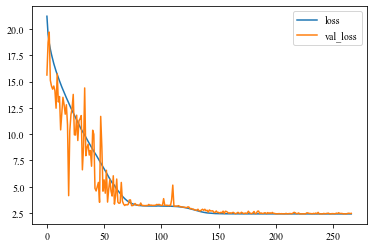

In [64]:
# Plot the loss and validation curves vs epoch
history_df = pd.DataFrame(history.history)
np.log(history_df.loc[:, ["loss", "val_loss"]]).plot()
history_df.to_csv(
    '/home/physics/phujdj/DeepLearningParticlePhysics/historyN.csv')


In [65]:
#Print the time it took for the neural network to train
print(sum(cb.logs))

1502.2774524907582


In [66]:
# Output to the console the minimum epoch
print("Minimum validation loss: {}".format(history_df["loss"].min()))

Minimum validation loss: 11.195158958435059


In [68]:
# Evaluate the entire performance of the model
loss = DeepNet.evaluate(tracks, bhads_targets, verbose=2)
print("The Loaded DeepNet has loss: ", loss)

2130/2130 - 4s - loss: 11.2314 - Mean_Squared_Error: 11524934656.0000 - 4s/epoch - 2ms/step
The Loaded DeepNet has loss:  [11.231403350830078, 11524934656.0]


In [157]:
#Rescale the predictions
Predictions = DeepNet.predict(tracks)
print(Predictions.shape)

2130/2130 [==============================] - 4s 2ms/step
(68143, 45)


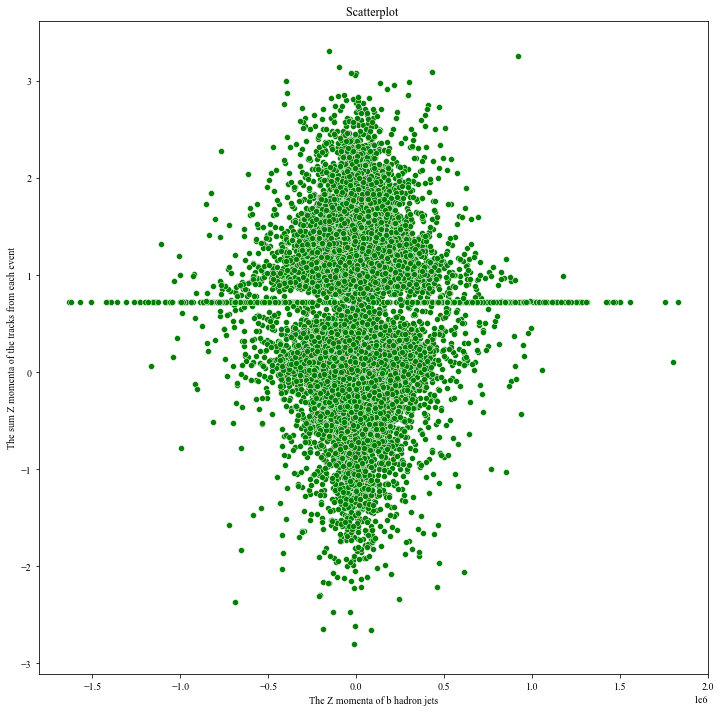

In [79]:
fig,ax = plt.subplots(figsize = (12,12))
sns.scatterplot(
    x = y_valid[:,2],
    y = Predictions[:,2],
    color = "green"
)
ax.set_title("Scatterplot ")
ax.set_ylabel("The sum Z momenta of the tracks from each event")
ax.set_xlabel("The Z momenta of b hadron jets")
plt.show()

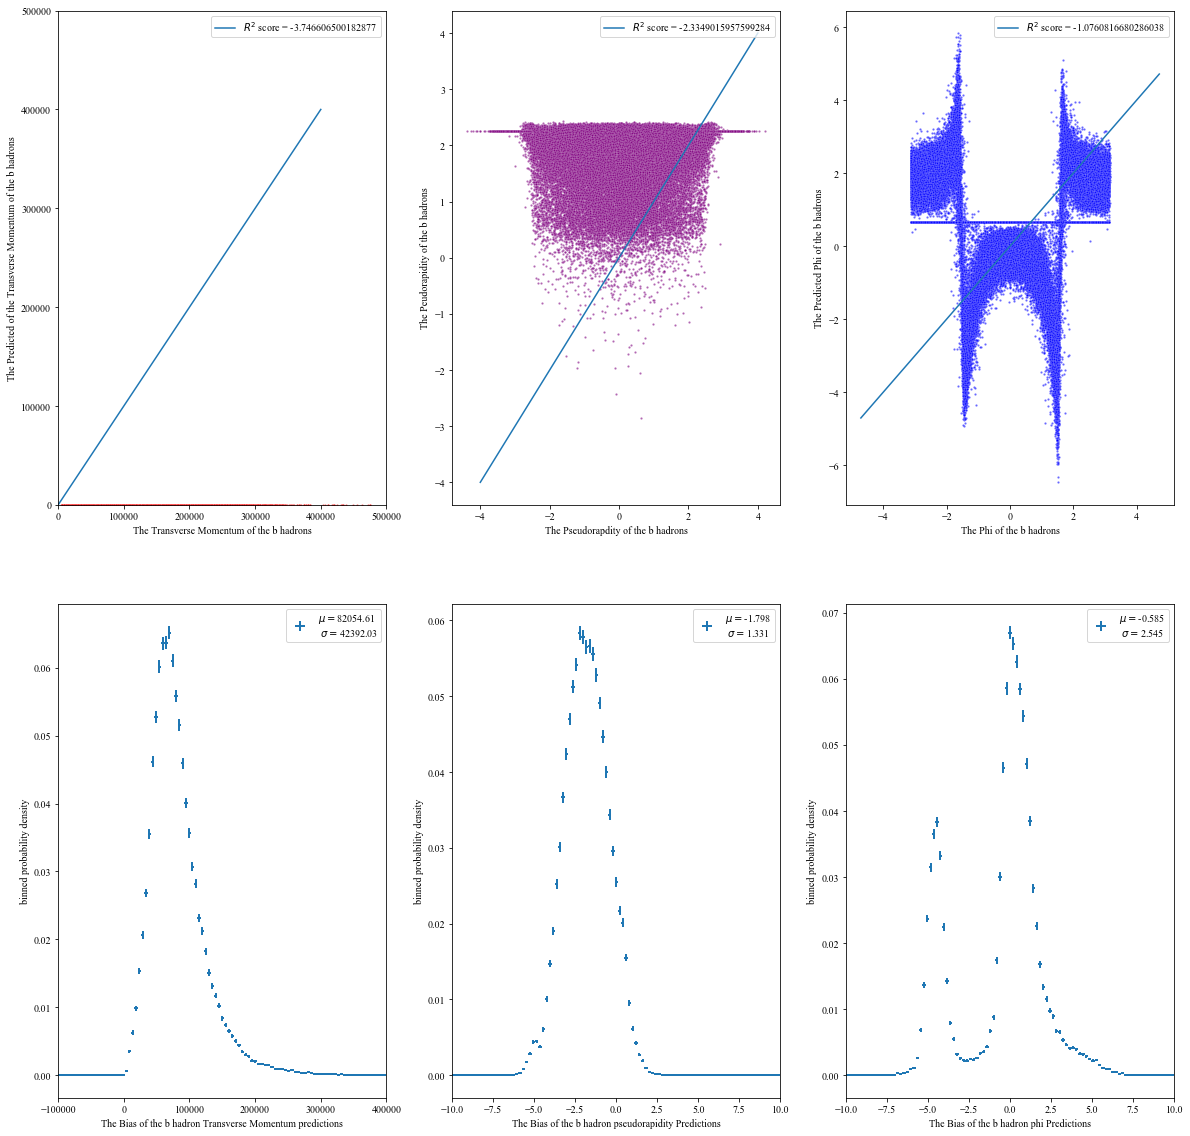

In [158]:
from sklearn.metrics import r2_score
from hffrag import binneddensitysub
Figure, axes = plt.subplots(2,3, figsize = (20,20))
l1 = sns.scatterplot(x = bhads_targets[:,3], y = Predictions[:,3], ax = axes[0,0], s = 5, alpha = 0.6, color = "red")
l1_score = r2_score(bhads_targets[:,3], Predictions[:,3])
x = np.linspace(0, 4e5)
l1.set_xlabel("The Transverse Momentum of the b hadrons")
l1.set_ylabel("The Predicted of the Transverse Momentum of the b hadrons")
error_pt = bhads_targets[:,3] - Predictions[:,3]
mean_error_pt, std_error_pt = np.mean(error_pt), np.std(error_pt)
l1.plot(x,x)
binneddensitysub(error_pt, fixedbinning(-1e5,4e5,100), ax = axes[1,0], xlabel= "The Bias of the b hadron Transverse Momentum predictions")
l2 = sns.scatterplot(x = bhads_targets[:,4], y = Predictions[:,4], ax = axes[0,1], s = 5, alpha = 0.6, color = "purple")
l2_score = r2_score(bhads_targets[:,4], Predictions[:,4])
x = np.linspace(-4, 4)
error_pseudorapidity = bhads_targets[:,4] - Predictions[:,4]
mean_error_pseudorapidity, std_error_psuedorapidity = np.mean(error_pseudorapidity), np.std(error_pseudorapidity)
l2.plot(x,x)
l2.set_xlabel("The Pseudorapdity of the b hadrons")
l2.set_ylabel("The Peudorapidity of the b hadrons")
binneddensitysub(error_pseudorapidity, fixedbinning(-10,10,100), ax = axes[1,1], xlabel="The Bias of the b hadron pseudorapidity Predictions")
l3 = sns.scatterplot(x = bhads_targets[:,5], y = Predictions[:,5], ax = axes[0,2], s = 5, alpha = 0.6, color = "blue")
l3_score = r2_score(bhads_targets[:,5], Predictions[:,5])
x = np.linspace(-1.5*np.pi, 1.5*np.pi)
error_phi = bhads_targets[:,5] - Predictions[:,5]
mean_error_phi, std_error_phi = np.mean(error_phi), np.std(error_phi)
l3.plot(x,x)
l3.set_xlabel("The Phi of the b hadrons")
l3.set_ylabel("The Predicted Phi of the b hadrons")
binneddensitysub(error_phi, fixedbinning(-10,10,100), ax = axes[1,2], xlabel="The Bias of the b hadron phi Predictions")
axes[0,0].set_ylim(0,5e5)
axes[0,0].legend([f"$R^2$ score = {l1_score}"], loc = "upper right")
axes[0,0].set_xlim(0,5e5)
axes[1,0].set_xlim(-1e5,4e5)
axes[1,0].legend([f"$\mu = ${round(mean_error_pt,2)}\n $\sigma = ${round(std_error_pt,2)}"], loc = "upper right")
axes[0,1].legend([f"$R^2$ score = {l2_score}"], loc = "upper right")
axes[1,1].set_xlim(-10,10)
axes[1,1].legend([f"$\mu = ${round(mean_error_pseudorapidity,3)}\n $\sigma = ${round(std_error_psuedorapidity,3)}"], loc = "upper right")
axes[0,2].legend([f"$R^2$ score = {l3_score}"], loc = "upper right")
axes[1,2].legend([f"$\mu = ${round(mean_error_phi,3)}\n $\sigma = ${round(std_error_phi,3)}"], loc = "upper right")
axes[1,2].set_xlim(-10,10)
plt.show()
Figure.savefig("/home/physics/phujdj/DeepLearningParticlePhysics/DeepSetsBase.png", dpi = 500)

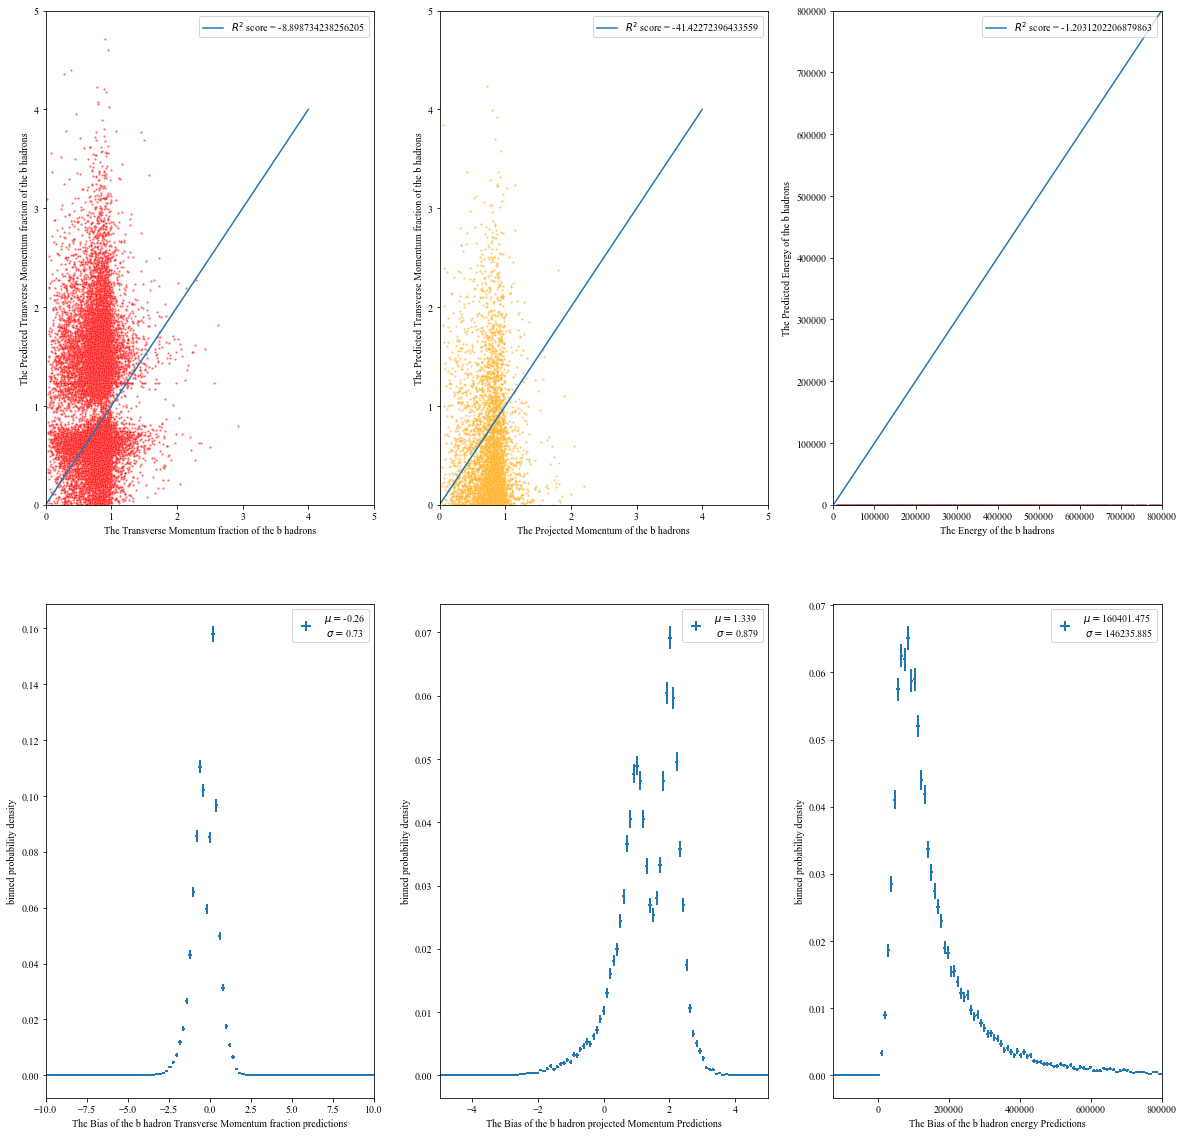

In [83]:
Figure, axes = plt.subplots(2,3, figsize = (20,20))
l1 = sns.scatterplot(x = y_valid[:,6], y = Predictions[:,6], ax = axes[0,0], s = 5, alpha = 0.6, color = "red")
l1_score = r2_score(y_valid[:,6], Predictions[:,6])
x = np.linspace(0, 4)
l1.set_xlabel("The Transverse Momentum fraction of the b hadrons")
l1.set_ylabel("The Predicted Transverse Momentum fraction of the b hadrons")
error_pt_fraction = y_valid[:,6] - Predictions[:,6]
mean_error_pt_fraction, std_error_pt_fraction = np.mean(error_pt_fraction), np.std(error_pt_fraction)
l1.plot(x,x)
binneddensitysub(error_pt_fraction, fixedbinning(-10,10,100), ax = axes[1,0], xlabel= "The Bias of the b hadron Transverse Momentum fraction predictions")
l2 = sns.scatterplot(x = y_valid[:,7], y = Predictions[:,7], ax = axes[0,1], s = 5, alpha = 0.6, color = "orange")
l2_score = r2_score(y_valid[:,7], Predictions[:,7])
x = np.linspace(0, 4)
error_projection = y_valid[:,7] - Predictions[:,7]
mean_error_projection, std_error_projection = np.mean(error_projection), np.std(error_projection)
l2.plot(x,x)
l2.set_xlabel("The Projected Momentum of the b hadrons")
l2.set_ylabel("The Predicted Transverse Momentum fraction of the b hadrons")
binneddensitysub(error_projection, fixedbinning(-5,5,100), ax = axes[1,1], xlabel="The Bias of the b hadron projected Momentum Predictions")
l3 = sns.scatterplot(x = y_valid[:,8], y = Predictions[:,8], ax = axes[0,2], s = 5, alpha = 0.6, color = "brown")
l3_score = r2_score(y_valid[:,8], Predictions[:,8])
x = np.linspace(0, 3e6)
error_energy = y_valid[:,8] - Predictions[:,8]
mean_error_energy, std_error_energy = np.mean(error_energy), np.std(error_energy)
l3.plot(x,x)
l3.set_xlabel("The Energy of the b hadrons")
l3.set_ylabel("The Predicted Energy of the b hadrons")
binneddensitysub(error_energy, fixedbinning(-1.25e5,8e5,100), ax = axes[1,2], xlabel="The Bias of the b hadron energy Predictions")
axes[0,0].set_ylim(0,5)
axes[0,0].legend([f"$R^2$ score = {l1_score}"], loc = "upper right")
axes[0,0].set_xlim(0,5)
axes[1,0].legend([f"$\mu = ${round(mean_error_pt_fraction,2)}\n $\sigma = ${round(std_error_pt_fraction,2)}"], loc = "upper right")
axes[0,1].set_xlim(0,5)
axes[0,1].set_ylim(0,5)
axes[0,1].legend([f"$R^2$ score = {l2_score}"], loc = "upper right")
axes[1,1].legend([f"$\mu = ${round(mean_error_projection,3)}\n $\sigma = ${round(std_error_projection,3)}"], loc = "upper right")
axes[0,2].legend([f"$R^2$ score = {l3_score}"], loc = "upper right")
axes[1,2].legend([f"$\mu = ${round(mean_error_energy,3)}\n $\sigma = ${round(std_error_energy,3)}"], loc = "upper right")
axes[0,2].set_ylim(0,8e5)
axes[0,2].set_xlim(0,8e5)
axes[1,0].set_xlim(-10,10)
axes[1,1].set_xlim(-5,5)
axes[1,2].set_xlim(-1.25e5,8e5)
Figure.savefig("/home/physics/phujdj/DeepLearningParticlePhysics/DeepSets2.png", dpi = 500)

In [102]:
#Below calculates the resolutions, resolutions scaled by 
#standard deviation of bhads.
Predictions.shape
y_train.shape

(47700, 9)

In [147]:
Error_pt = y_valid[:,3] - Predictions[:,3]
Pull_bhads_pt = Error_pt/np.std(y_valid[:,3])
Pull_pt = Error_pt/Predictions[:,12]
Pull_pt_mean, Pull_pt_std = np.mean(Pull_pt), np.std(Pull_pt)

In [148]:
Error_eta = y_valid[:,4] - Predictions[:,4]
Pull_bhads_eta = Error_eta/np.std(y_valid[:,4])
Pull_eta = Error_eta/Predictions[:,13]
Pull_eta_mean, Pull_eta_std = np.mean(Pull_eta), np.std(Pull_eta)

In [149]:
Error_phi = y_valid[:,5] - Predictions[:,5]
Pull_bhads_phi = Error_phi/np.std(y_valid[:,5])
Pull_phi = Error_phi/Predictions[:,14]
Pull_phi_mean, Pull_phi_std = np.mean(Pull_phi), np.std(Pull_phi)

In [150]:
Error_pt_fraction = y_valid[:,6] - Predictions[:,6]
Pull_bhads_pt_fraction = Error_pt_fraction/np.std(y_valid[:,6])
Pull_pt_fraction = Error_pt_fraction/Predictions[:,15]
Pull_pt_mean_fraction, Pull_pt_std_fraction = np.mean(Pull_bhads_pt_fraction), np.std(Pull_pt_fraction)

In [151]:
Error_projection = y_valid[:,7] - Predictions[:,7]
Pull_bhads_projection = Error_projection/np.std(y_valid[:,7])
Pull_projection = Error_projection/Predictions[:,16]
Pull_projection_mean, Pull_projection_std = np.mean(Pull_projection), np.std(Pull_projection)

In [152]:
Error_energy = y_valid[:,8] - Predictions[:,8]
Pull_bhads_energy = Error_energy/np.std(y_valid[:,8])
Pull_energy = Error_energy/Predictions[:,17]
Pull_energy_mean, Pull_energy_std = np.mean(Pull_energy), np.std(Pull_energy)

-52298646.55134889

In [ ]:
#Plot the results:

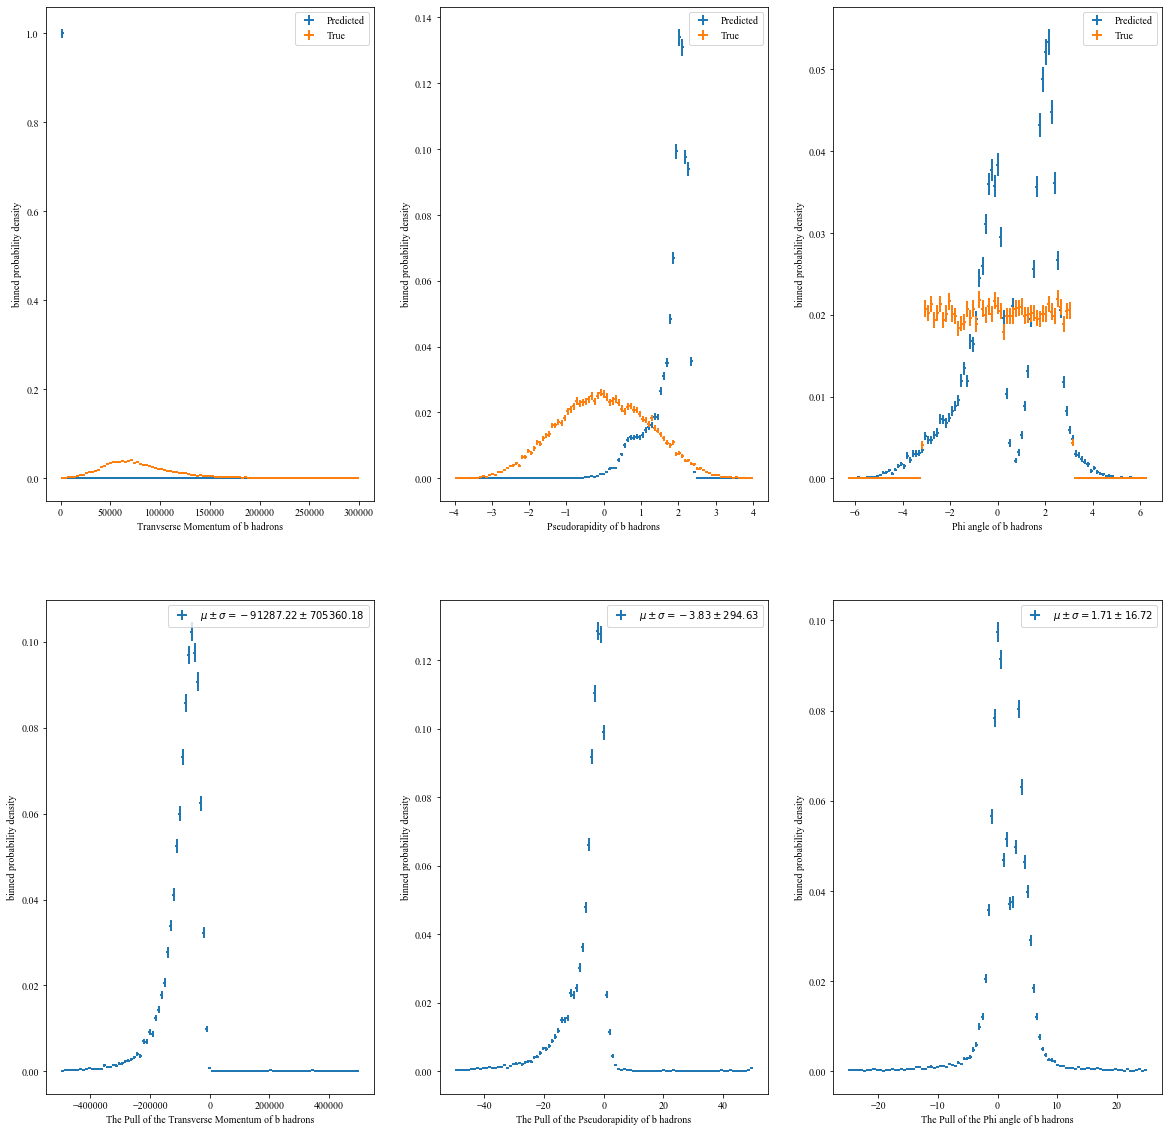

In [155]:
Figure, axes = plt.subplots(2,3, figsize = (20,20))
l1 = binneddensitysub(Predictions[:,3], fixedbinning(0,3e5,100), ax = axes[0,0], xlabel = "Predicted Tranvserse Momentum of b hadrons", label = "Predicted")
l2 = binneddensitysub(Predictions[:,4], fixedbinning(-4,4,100), ax = axes[0,1], xlabel = "Predicted Pseudorapidity Momentum of b hadrons", label = "Predicted")
l3 = binneddensitysub(Predictions[:,5], fixedbinning(-2*np.pi,2*np.pi,100), ax = axes[0,2], xlabel = "Predicted Phi Angle of b hadrons", label = "Predicted")
l4 = binneddensitysub(y_valid[:,3], fixedbinning(0,3e5,100), ax = axes[0,0], xlabel = "Tranvserse Momentum of b hadrons", label = "True")
l5 = binneddensitysub(y_valid[:,4], fixedbinning(-4, 4, 100), ax = axes[0,1], xlabel= "Pseudorapidity of b hadrons", label = "True")
l6 = binneddensitysub(y_valid[:,5], fixedbinning(-2*np.pi,2*np.pi,100), ax = axes[0,2], xlabel = "Phi angle of b hadrons", label = "True")
l7 = binneddensitysub(Pull_pt, fixedbinning(-5e5,5e5,100), ax = axes[1,0], xlabel = "The Pull of the Transverse Momentum of b hadrons",)
l8 = binneddensitysub(Pull_eta, fixedbinning(-50,50,100), ax = axes[1,1], xlabel = "The Pull of the Pseudorapidity of b hadrons")
l9 = binneddensitysub(Pull_phi, fixedbinning(-25,25,100), ax = axes[1,2], xlabel = "The Pull of the Phi angle of b hadrons")
axes[1,0].legend([f"$\mu \pm \sigma = {round(Pull_pt_mean,2)} \pm {round(Pull_pt_std,2)}$"])
axes[1,1].legend([f"$\mu \pm \sigma = {round(Pull_eta_mean,2)} \pm {round(Pull_eta_std,2)}$"])
axes[1,2].legend([f"$\mu \pm \sigma = {round(Pull_phi_mean,2)} \pm {round(Pull_phi_std,2)}$"])
axes[0,0].legend(loc = "upper right")
axes[0,1].legend(loc = "upper right")
axes[0,2].legend(loc = "upper right")
Figure.savefig("/home/physics/phujdj/DeepLearningParticlePhysics/DeepSetsBase3.png", dpi = 500)

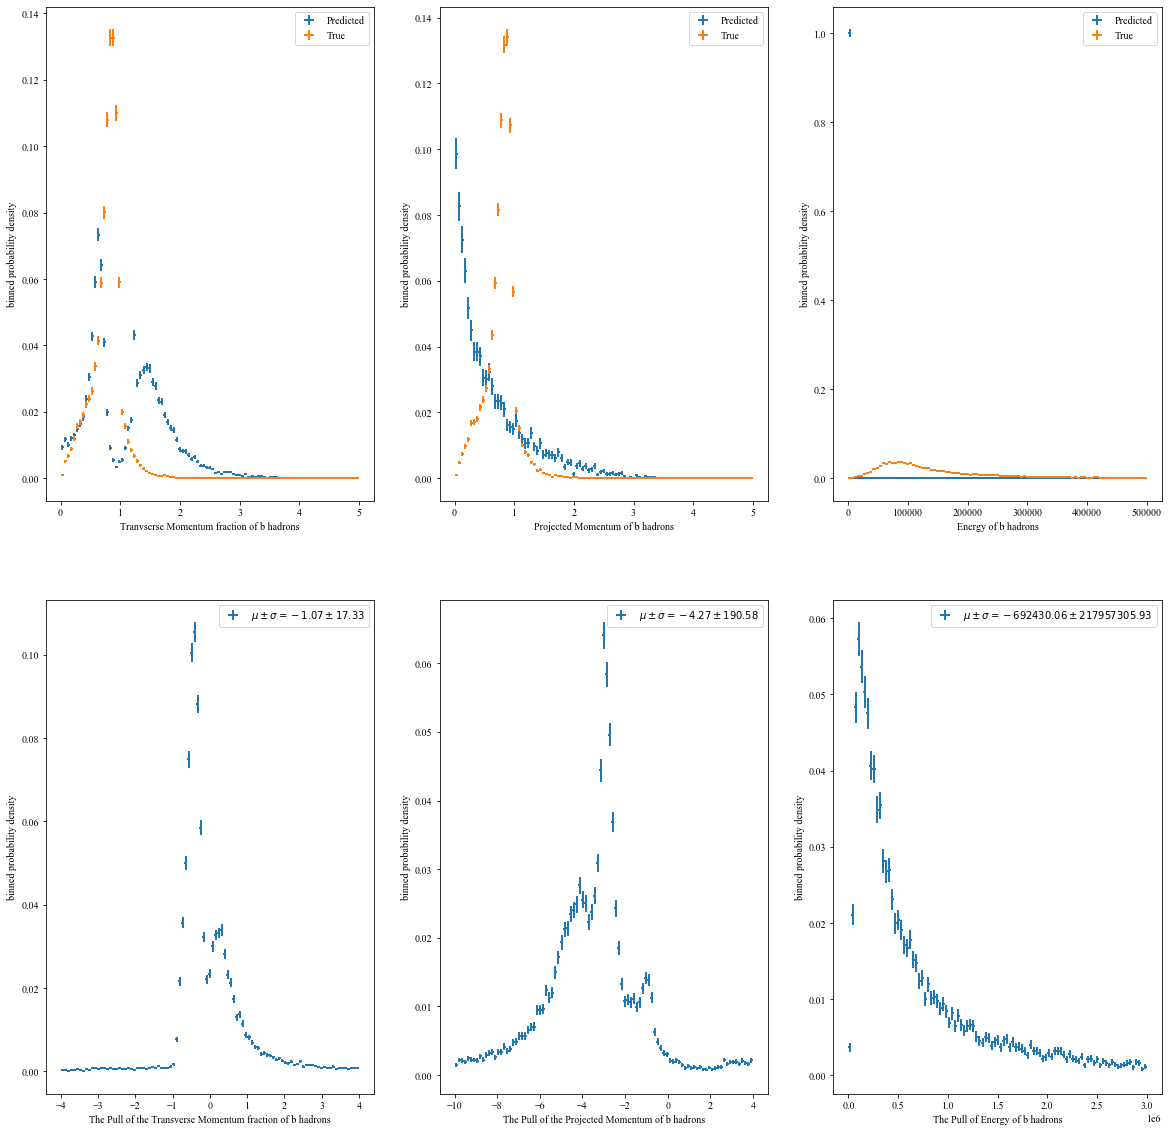

In [156]:
Figure, axes = plt.subplots(2,3, figsize = (20,20))
l1 = binneddensitysub(Predictions[:,6], fixedbinning(0,5,100), ax = axes[0,0], xlabel = "Predicted Tranvserse Momentum fraction of b hadrons", label = "Predicted")
l2 = binneddensitysub(Predictions[:,7], fixedbinning(0,5,100), ax = axes[0,1], xlabel = "Predicted Projected Momentum of b hadrons", label = "Predicted")
l3 = binneddensitysub(Predictions[:,8], fixedbinning(0,5e5,100), ax = axes[0,2], xlabel = "Predicted Energy of b hadrons", label = "Predicted")
l4 = binneddensitysub(y_valid[:,6], fixedbinning(0,5,100), ax = axes[0,0], xlabel = "Tranvserse Momentum fraction of b hadrons", label = "True")
l5 = binneddensitysub(y_valid[:,7], fixedbinning(0, 5, 100), ax = axes[0,1], xlabel= "Projected Momentum of b hadrons", label = "True")
l6 = binneddensitysub(y_valid[:,8], fixedbinning(0,5e5,100), ax = axes[0,2], xlabel = "Energy of b hadrons", label = "True")
l7 = binneddensitysub(Pull_pt_fraction, fixedbinning(-4,4,100), ax = axes[1,0], xlabel = "The Pull of the Transverse Momentum fraction of b hadrons",)
l8 = binneddensitysub(Pull_projection, fixedbinning(-10,4,100), ax = axes[1,1], xlabel = "The Pull of the Projected Momentum of b hadrons")
l9 = binneddensitysub(Pull_energy, fixedbinning(-0,3e6,100), ax = axes[1,2], xlabel = "The Pull of Energy of b hadrons")
axes[1,0].legend([f"$\mu \pm \sigma = {round(Pull_pt_mean_fraction,2)} \pm {round(Pull_pt_std_fraction,2)}$"])
axes[1,1].legend([f"$\mu \pm \sigma = {round(Pull_projection_mean,2)} \pm {round(Pull_projection_std,2)}$"])
axes[1,2].legend([f"$\mu \pm \sigma = {round(Pull_energy_mean,2)} \pm {round(Pull_energy_std,2)}$"])
axes[0,0].legend(loc = "upper right")
axes[0,1].legend(loc = "upper right")
axes[0,2].legend(loc = "upper right")
Figure.savefig("/home/physics/phujdj/DeepLearningParticlePhysics/DeepSetsBase4.png", dpi = 500)

157.24938074724898
64623.163799725255


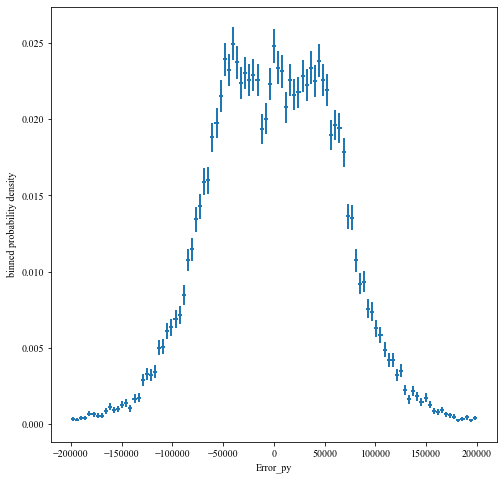

In [89]:
print(np.mean(Error_px))
print(np.std(Error_px))
binneddensity(Error_px, fixedbinning(-200000,200000,100),xlabel = "Error_py")

-452.26335541719794
65180.540836875545


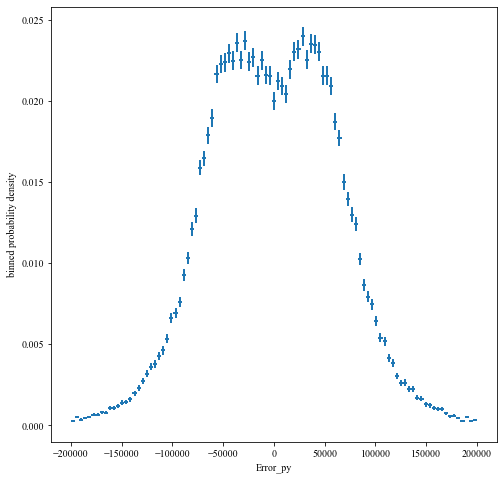

In [55]:
print(np.mean(Error_py))
print(np.std(Error_py))
binneddensity(Error_py, fixedbinning(-200000,200000,100),xlabel = "Error_py")

1115.1436393822069
197152.30857000625


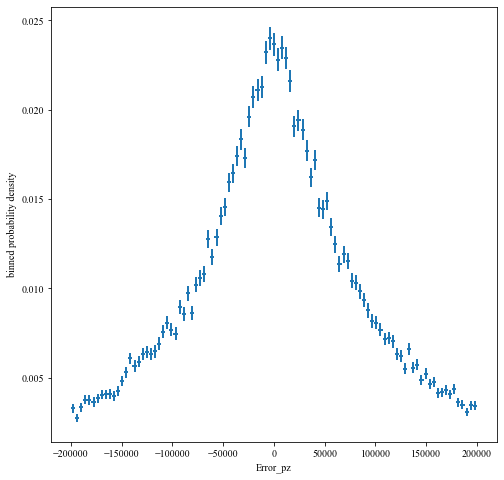

In [57]:
print(np.mean(Error_pz))
print(np.std(Error_pz))
binneddensity(Error_pz, fixedbinning(-200000,200000,100),xlabel = "Error_pz")

0.00633039341605163
1.6588855270879757


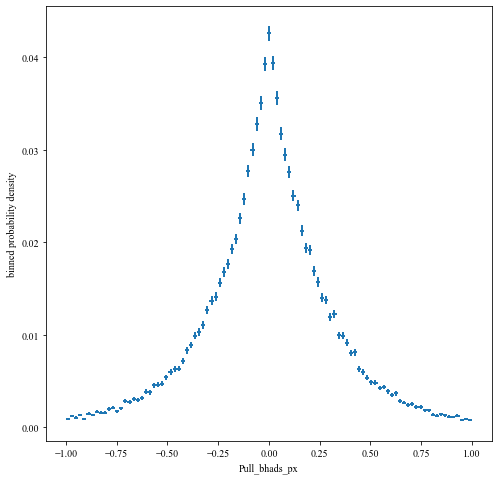

In [ ]:
print(np.mean(Pull_bhads_px))
print(np.std(Pull_bhads_px))
binneddensity(Pull_bhads_px, fixedbinning(-1,1,100),xlabel = "Pull_bhads_px")

-0.018110381389166794
2.4080751467149026


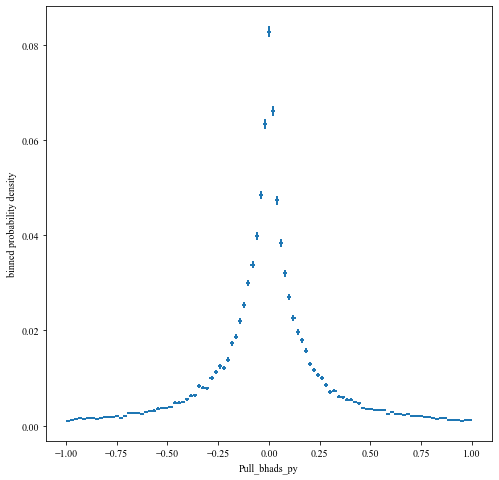

In [ ]:
print(np.mean(Pull_bhads_py))
print(np.std(Pull_bhads_py))
binneddensity(Pull_bhads_py, fixedbinning(-1,1,100),xlabel = "Pull_bhads_py")

-0.05929451963445168
1.0160428145600089


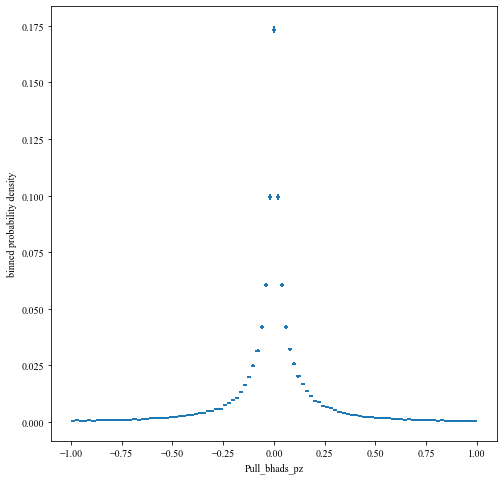

In [ ]:
print(np.mean(Pull_bhads_pz))
print(np.std(Pull_bhads_pz))
binneddensity(Pull_bhads_pz, fixedbinning(-1,1,100),xlabel = "Pull_bhads_pz")

In [ ]:
#Belows plots the scatter plots of the true bhadron targets vs the neural networks predicted bhadron targets

Text(0, 0.5, 'The predicted X momenta of b hadron jets')

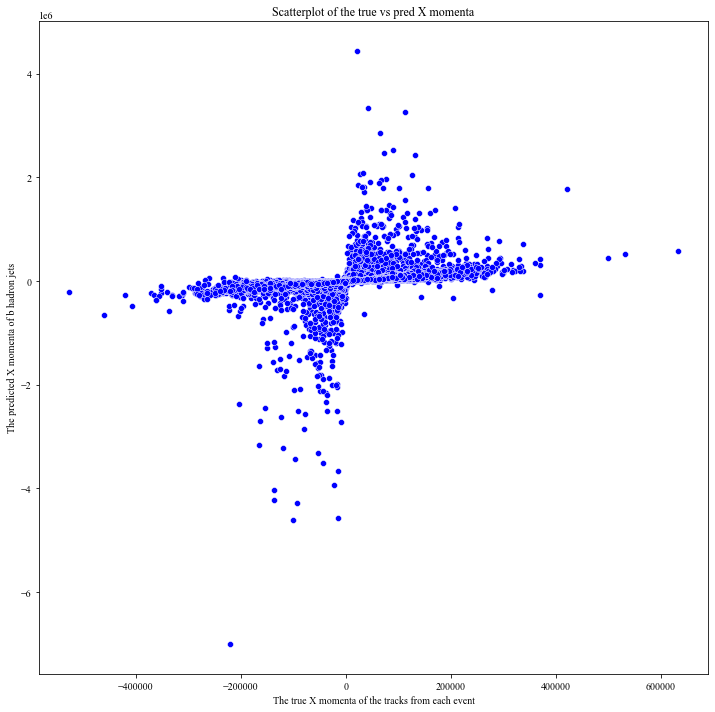

In [ ]:
fig,ax = plt.subplots(figsize = (12,12))
sns.scatterplot(
    y = Predictions_px,
    x = bhads[:,0],
    color = "blue"
)
ax.set_title("Scatterplot of the true vs pred X momenta")
ax.set_xlabel("The true X momenta of the tracks from each event")
ax.set_ylabel("The predicted X momenta of b hadron jets")

Text(0, 0.5, 'The predicted Y momenta of b hadron jets')

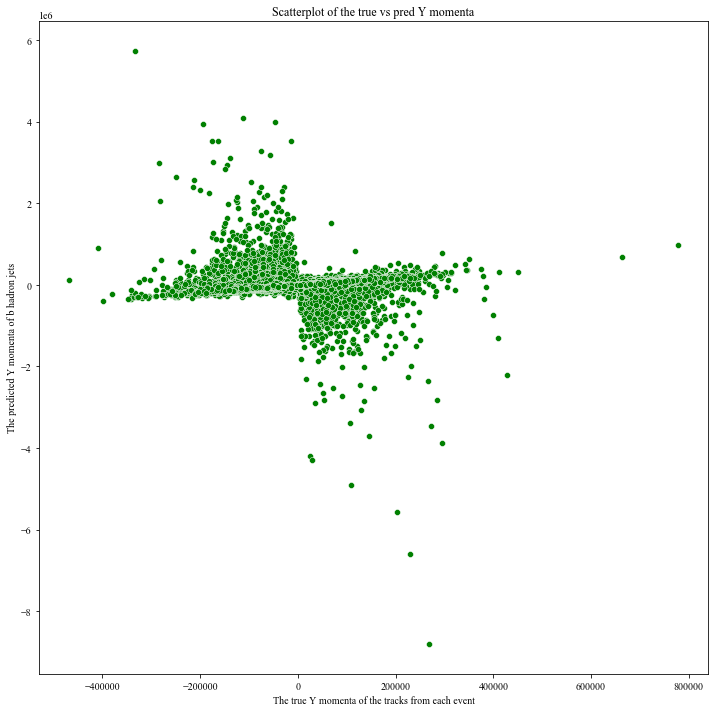

In [ ]:
fig,ax = plt.subplots(figsize = (12,12))
sns.scatterplot(
    y = Predictions_py,
    x = bhads[:,1],
    color = "green"
)
ax.set_title("Scatterplot of the true vs pred Y momenta")
ax.set_xlabel("The true Y momenta of the tracks from each event")
ax.set_ylabel("The predicted Y momenta of b hadron jets")

Text(0, 0.5, 'The predicted Z momenta of b hadron jets')

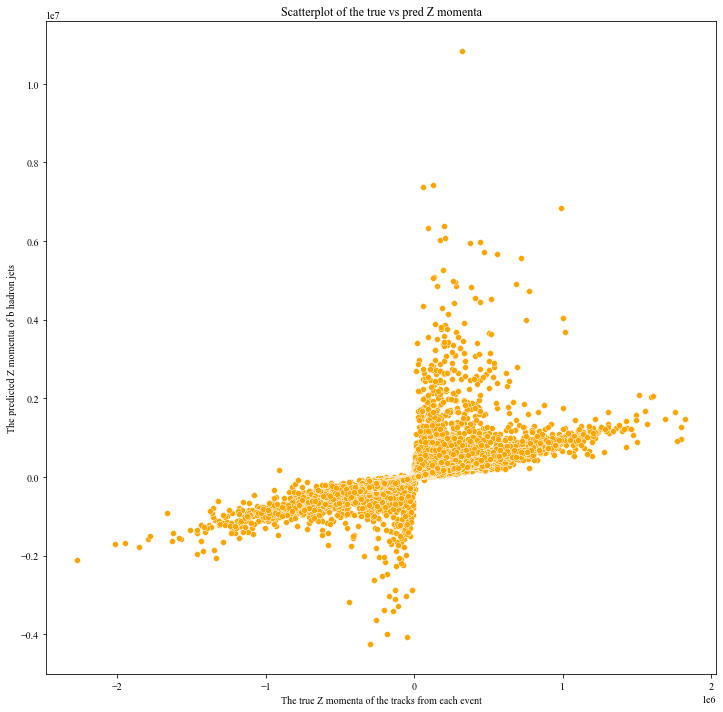

In [ ]:
fig,ax = plt.subplots(figsize = (12,12))
sns.scatterplot(
    y = Predictions_pz,
    x = bhads[:,2],
    color = "orange"
)
ax.set_title("Scatterplot of the true vs pred Z momenta")
ax.set_xlabel("The true Z momenta of the tracks from each event")
ax.set_ylabel("The predicted Z momenta of b hadron jets")

In [ ]:
#Gets the outputs coming from the sum layer
get_sum_layer_output = k.function([DeepNet.layers[0].input],
                                  [DeepNet.layers[13].output])
layer_output = get_sum_layer_output(tracks)[0]
print(layer_output.shape)
layer_output_jet = np.mean(layer_output, axis  = 1)

(68143, 34)


In [ ]:
#Reverses the output of the sum layer and bhad targets
layer_output_reverse = np.reshape(layer_output, (34,-1))
bhads_output = np.reshape(bhads, (3,-1))

#Computes the average across the layer
layer_output_average = np.mean(layer_output_reverse, axis = -1)
HistLayer = np.stack([np.arange(34), layer_output_average])

#Forms a matrix consists of the features and targets
X = np.concatenate([layer_output_reverse, bhads_output])
X[np.shape(X)[0] - np.shape(bhads_output)[0]:,:]

#Calculates the pearson correlation matrix
Pearson_Correlation_Matrix = np.corrcoef(X)

In [ ]:
#Extracts the correlation between the bhadron x, and z momenta and the features coming out the sum layer. 
#Then produces histograms for them.
Correlation_X = Pearson_Correlation_Matrix[:32,32:][:,0]
HistX = np.stack([np.arange(32), Correlation_X])

Correlation_Y = Pearson_Correlation_Matrix[:32,32:][:,1]
HistY = np.stack([np.arange(32), Correlation_Y])

Correlation_Z = Pearson_Correlation_Matrix[:32,32:][:,2]
HistZ = np.stack([np.arange(32), Correlation_Z])

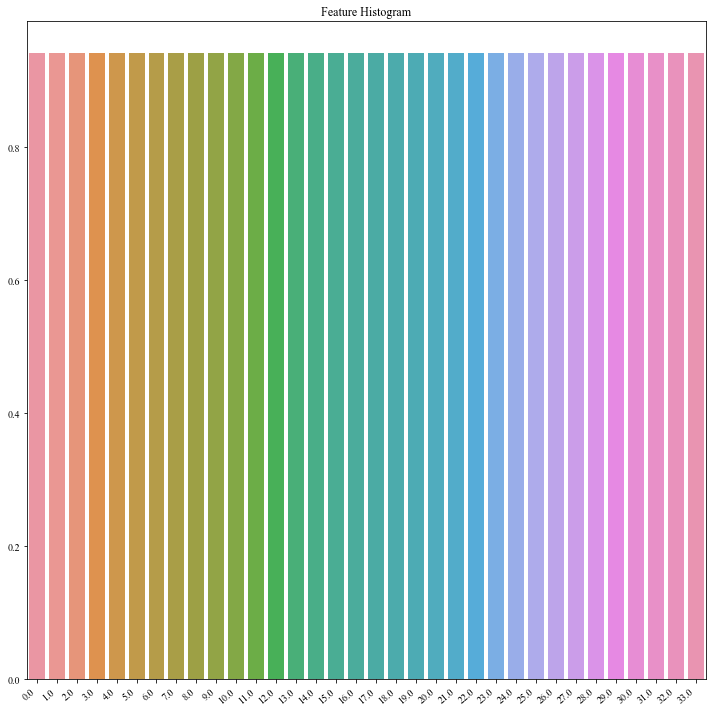

In [ ]:
#Plots the feature histogram coming out from the sum layer averaged arcoss the tracks and then averaged across the jets
plt.figure(figsize = (10,10))
ax = sns.barplot(x = HistLayer[0,:], y = HistLayer[1,:])
ax.set_title("Feature Histogram")
plt.setp(ax.get_xticklabels(), rotation=40, horizontalalignment='right') 
plt.tight_layout()

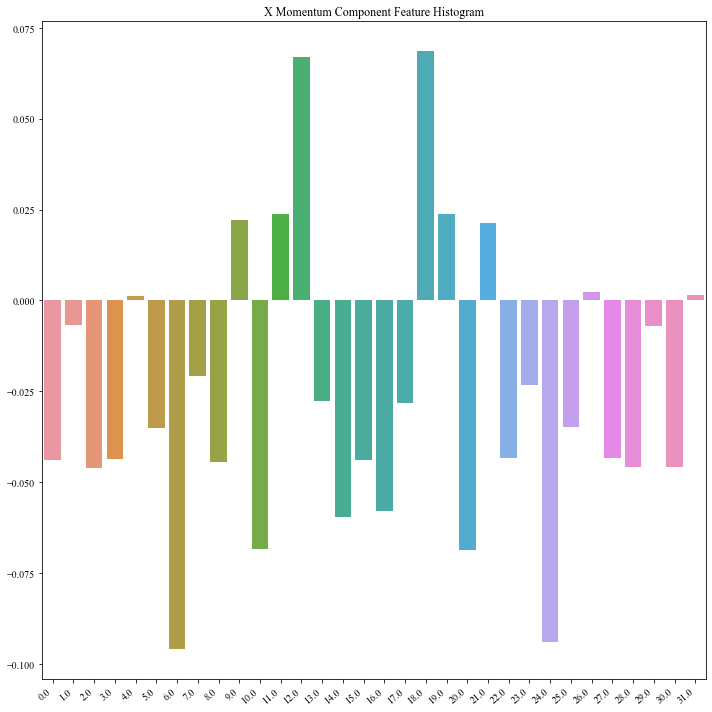

In [ ]:
#Displays the histogram of correlations between the bhadron's x momentum and the features coming out the sum layer.
plt.figure(figsize = (10,10))
ax = sns.barplot(x = HistX[0,:], y = HistX[1,:])
ax.set_title("X Momentum Component Feature Histogram")
plt.setp(ax.get_xticklabels(), rotation=40, horizontalalignment='right') 
plt.tight_layout()


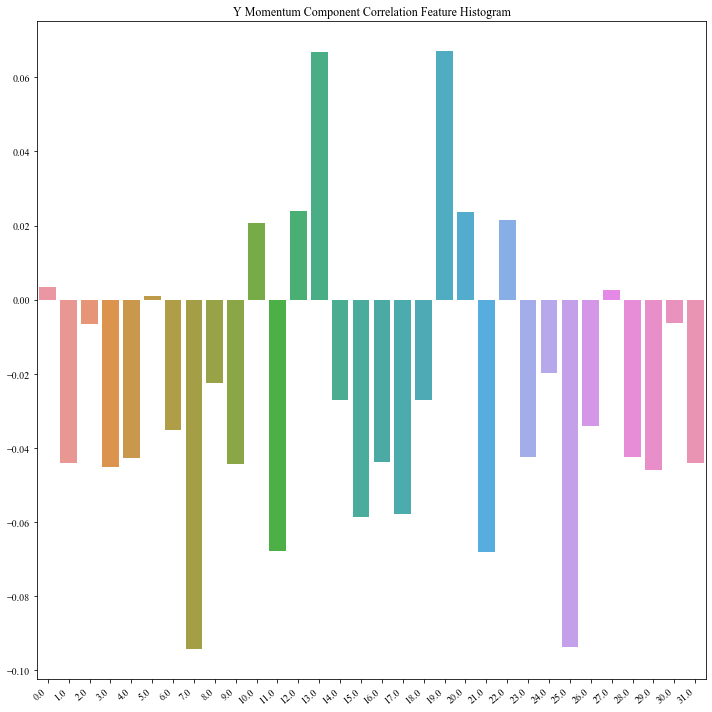

In [ ]:
#Displays the histogram of correlations between the bhadron's y momentum and the features coming out the sum layer.
plt.figure(figsize = (10,10))
ax = sns.barplot(x = HistY[0,:], y = HistY[1,:])
ax.set_title("Y Momentum Component Correlation Feature Histogram")
plt.setp(ax.get_xticklabels(), rotation=40, horizontalalignment='right') 
plt.tight_layout()

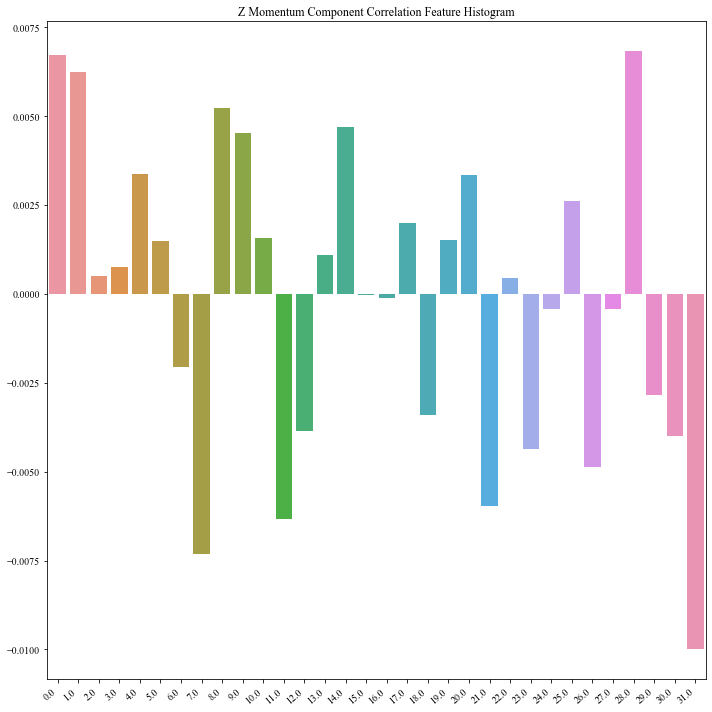

In [ ]:
#Displays the histogram of correlations between the bhadron's z momentum and the features coming out the sum layer.
plt.figure(figsize = (10,10))
ax = sns.barplot(x = HistZ[0,:], y = HistZ[1,:])
ax.set_title("Z Momentum Component Correlation Feature Histogram")
plt.setp(ax.get_xticklabels(), rotation=40, horizontalalignment='right') 
plt.tight_layout()

In [ ]:
#Calculates the mutual information scores between the features coming out the sum layer and the bhadron x momenta
mi_scores_px_momentum = make_mi_scores(layer_output, bhads[:,0])
print(mi_scores_px_momentum)

7     0.382221
21    0.352690
11    0.291611
13    0.289769
10    0.281627
32    0.249355
22    0.234853
12    0.218585
29    0.194509
24    0.168032
18    0.166404
17    0.157391
3     0.135436
9     0.108070
14    0.094890
2     0.088648
8     0.077399
23    0.075427
16    0.066009
4     0.065281
28    0.061661
30    0.061547
6     0.054776
5     0.053415
25    0.045229
1     0.044926
19    0.035774
0     0.034728
33    0.031568
20    0.030182
15    0.026449
31    0.023650
27    0.021589
26    0.021483
Name: MI Scores, dtype: float64


In [ ]:
#Calculates the mutual information scores between the features coming out the sum layer and the bhadron y momenta
mi_scores_py_momentum = make_mi_scores(layer_output, bhads[:,1])
print(mi_scores_py_momentum)

5     0.103597
1     0.069941
22    0.056999
7     0.055532
25    0.039211
21    0.038265
30    0.037712
9     0.035626
10    0.032015
32    0.029027
8     0.028226
29    0.027843
3     0.027427
6     0.027357
28    0.026983
18    0.026936
12    0.026713
19    0.026116
17    0.025792
4     0.025659
2     0.024575
11    0.023974
16    0.023186
24    0.023082
23    0.022047
14    0.021844
13    0.021192
20    0.020446
33    0.020122
31    0.019770
27    0.017327
0     0.014583
26    0.013997
15    0.012716
Name: MI Scores, dtype: float64


In [ ]:
#Calculates the mutual information scores between the features coming out the sum layer and the bhadron z momenta
mi_scores_pz_momentum = make_mi_scores(layer_output, bhads[:,2])
print(mi_scores_pz_momentum)

23    0.514213
19    0.479201
31    0.469880
28    0.466135
0     0.461737
6     0.440606
30    0.439636
4     0.413661
33    0.372157
14    0.336040
9     0.323502
2     0.298869
17    0.290544
20    0.283961
25    0.281273
1     0.280567
3     0.270421
16    0.266320
8     0.263173
27    0.233573
15    0.219698
12    0.197276
18    0.194281
26    0.189791
13    0.173276
24    0.166649
29    0.154282
22    0.141496
10    0.126934
21    0.124799
11    0.116972
32    0.113941
5     0.105008
7     0.102652
Name: MI Scores, dtype: float64


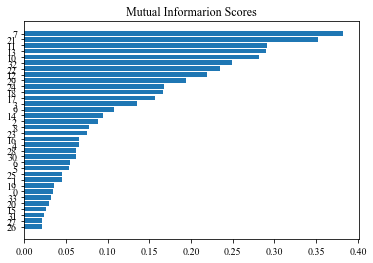

In [ ]:
#Displays the mutual information scores between the output of the sum layer and the bhadron x momenta
plt.Figure(dpi=200, figsize=(100, 100))
plot_mi_scores(mi_scores_px_momentum)

In [ ]:
mi_scores_px_momentum =  make_mi_scores(Predictions, bhads[:,0])
print(mi_scores_px_momentum)

2    0.157121
1    0.059341
0    0.041958
Name: MI Scores, dtype: float64


In [ ]:
mi_scores_py_momentum =  make_mi_scores(Predictions, bhads[:,1])
print(mi_scores_py_momentum)

2    0.021095
1    0.015264
0    0.012183
Name: MI Scores, dtype: float64


In [ ]:
mi_scores_pz_momentum =  make_mi_scores(Predictions, bhads[:,2])
print(mi_scores_px_momentum)

2    0.157121
1    0.059341
0    0.041958
Name: MI Scores, dtype: float64
